[Оригинальный файл на Kaggle](https://www.kaggle.com/code/sharthz23/metrics-validation-strategies-and-baselines)

# Расчёт метрик

In [19]:
import os
from collections import defaultdict

from more_itertools import pairwise
import pandas as pd
import polars as pl
import seaborn as sns

In [20]:
sns.set_style("darkgrid")

In [21]:
%load_ext autoreload
%autoreload 2

from recs_utils.metrics import precision_at_k, join_true_pred_and_preprocess, recall_at_k, mean_reciprocal_rank, mean_average_prec
from recs_utils.load_data import MTSDataset, sample_true_rec_data
from recs_utils.simple_rec import PopularRecommender, PopularRecommenderPerAge
from recs_utils.split import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
data_dir = "data"

In [23]:
df = MTSDataset.load_interactions(os.path.join(data_dir, "interactions.csv"))
df_users = MTSDataset.load_users(os.path.join(data_dir, "users.csv"))
df_items = MTSDataset.load_items(os.path.join(data_dir, "items.csv"))

In [25]:
df.head()

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
126706,14433,80,NaN,2018-01-01
127290,140952,58,NaN,2018-01-01
66991,198453,89,NaN,2018-01-01
46791,83486,23,5.0,2018-01-01
79313,188770,88,5.0,2018-01-01


In [26]:
df.select("rating").unique()

rating
f32
2.0
4.0
5.0
NaN
1.0
3.0


In [27]:
sample_true, sample_rec = sample_true_rec_data()

In [28]:
joined_data = join_true_pred_and_preprocess(sample_true, sample_rec)

In [29]:
joined_data

user_id,item_id,rank,item_count_per_user
str,str,f64,u32
"""Аня""","""Мастер и Марга…",NaN,1
"""Боря""","""451° по Фаренг…",1.0,1
"""Вася""","""Зеленая миля""",3.0,2
"""Вася""","""Рита Хейуорт и…",NaN,2


In [30]:
joined_data = join_true_pred_and_preprocess(sample_true, sample_rec)

In [31]:
metric_value, joined_data = precision_at_k(joined_data, k=2)

In [32]:
metric_value

0.16666666666666666

In [33]:
joined_data

user_id,item_id,rank,item_count_per_user,hit@2,hit@2/2
str,str,f64,u32,bool,f64
"""Аня""","""Мастер и Марга…",NaN,1,false,0.0
"""Боря""","""451° по Фаренг…",1.0,1,true,0.5
"""Вася""","""Зеленая миля""",3.0,2,false,0.0
"""Вася""","""Рита Хейуорт и…",NaN,2,false,0.0


In [34]:
metric_value, joined_data = recall_at_k(joined_data, 1)

In [35]:
metric_value

0.3333333333333333

In [36]:
joined_data

user_id,item_id,rank,item_count_per_user,hit@2,hit@2/2,hit@1
str,str,f64,u32,bool,f64,bool
"""Аня""","""Мастер и Марга…",NaN,1,false,0.0,false
"""Боря""","""451° по Фаренг…",1.0,1,true,0.5,true
"""Вася""","""Зеленая миля""",3.0,2,false,0.0,false
"""Вася""","""Рита Хейуорт и…",NaN,2,false,0.0,false


In [37]:
mean_reciprocal_rank(joined_data)

0.4444444444444444

In [38]:
mean_average_prec(joined_data)

0.3888888888888889

In [39]:
test_dates = df.select(pl.col("start_date").unique())[-7:].to_series().to_list()
test_dates = list(pairwise(test_dates))

In [40]:
test_dates

[(datetime.date(2019, 12, 25), datetime.date(2019, 12, 26)),
 (datetime.date(2019, 12, 26), datetime.date(2019, 12, 27)),
 (datetime.date(2019, 12, 27), datetime.date(2019, 12, 28)),
 (datetime.date(2019, 12, 28), datetime.date(2019, 12, 29)),
 (datetime.date(2019, 12, 29), datetime.date(2019, 12, 30)),
 (datetime.date(2019, 12, 30), datetime.date(2019, 12, 31))]

In [41]:
def validate(interactions: pl.DataFrame, user_features: pl.DataFrame, test_dates, model_cls):
    metrics = defaultdict(list)

    for i, split_pair in enumerate(test_dates):
        train, test = train_test_split(interactions, split_pair)
        baseline = model_cls()
        baseline.fit(train, user_features)

        test_user_features = test.join(user_features, on="user_id", how="left")
        predicted_recs = baseline.predict(test_user_features)

        assert predicted_recs.select(pl.col("user_id").n_unique())[0, 0] == test.select(pl.col("user_id").n_unique())[0, 0]

        estimated = join_true_pred_and_preprocess(test, predicted_recs)
        metrics["value"].append(mean_reciprocal_rank(estimated))
        metrics["name"].append("MRR")
        metrics["value"].append(mean_average_prec(estimated))
        metrics["name"].append("MAP")
        metrics["fold"] += [i] * 2

    return pd.DataFrame(metrics)

In [42]:
pop_metrics = validate(df, df_users, test_dates, PopularRecommender)

<Axes: xlabel='fold', ylabel='value'>

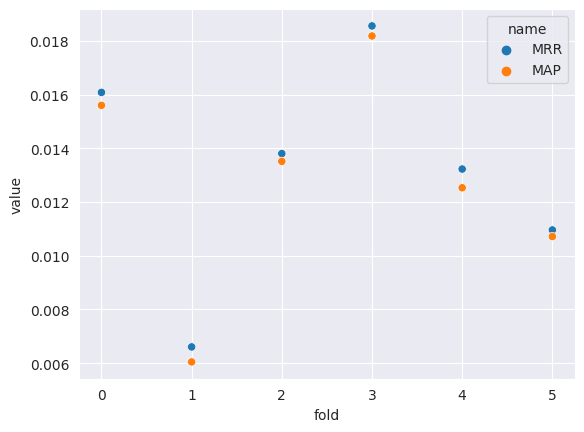

In [43]:
sns.scatterplot(data=pop_metrics, x="fold", y="value", hue="name")

In [44]:
pop_per_age_metrics = validate(df, df_users, test_dates, PopularRecommenderPerAge)

<Axes: xlabel='fold', ylabel='value'>

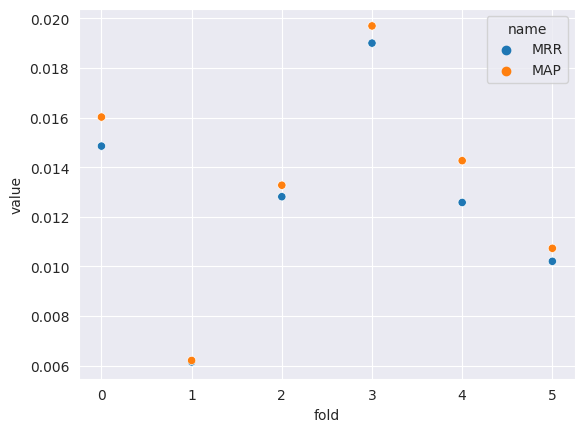

In [45]:
sns.scatterplot(data=pop_per_age_metrics, x="fold", y="value", hue="name")

In [46]:
pop_metrics["model"] = "popular"
pop_per_age_metrics["model"] = "popular_per_age"

In [47]:
all_metrics = pd.concat((pop_metrics, pop_per_age_metrics), axis="index", ignore_index=True)

In [48]:
all_metrics.head()

,value,name,fold,model
0,0.016082,MRR,0,popular
1,0.015599,MAP,0,popular
2,0.006603,MRR,1,popular
3,0.006045,MAP,1,popular
4,0.013803,MRR,2,popular


<Axes: xlabel='fold', ylabel='value'>

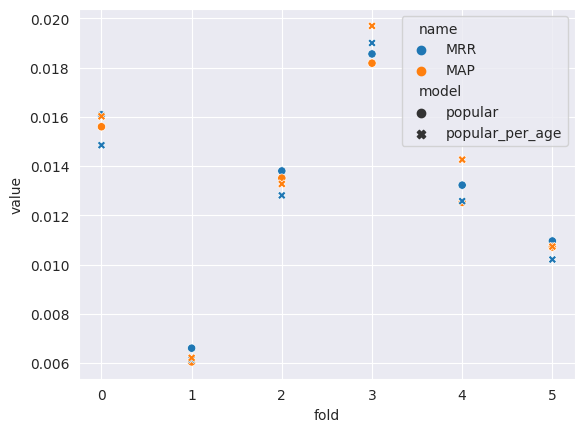

In [49]:
sns.scatterplot(data=all_metrics, x="fold", y="value", hue="name", style="model")